In [1]:
from __future__ import division, print_function, absolute_import

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import cv2
import os
import warnings
import sys
from PIL import Image
from timeit import time

from stereo_reconstruction import structure
from stereo_reconstruction import processor
from stereo_reconstruction import features

from yolo3_deepsort.yolo import YOLO
from yolo3_deepsort.deep_sort.detection import Detection,NMS
from yolo3_deepsort.deep_sort.tracker import Tracker
from yolo3_deepsort.tools import generate_detections as gdet
from yolo3_deepsort.tools.plot_utils import draw_one_box as draw_box
from yolo3_deepsort.deep_sort.detection import Detection as ddet
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
yolo = YOLO(model_path = 'yolo3_deepsort/model_data/trained_weights_coco.h5',
            classes_path = 'yolo3_deepsort/model_data/classes_name.txt',
            weights_only = True,
            score = 0.3,
            iou = 0.3)
video_handle = 'yolo3_deepsort/model_data/Crossroad.mp4'

yolo3_deepsort/model_data/trained_weights_coco.h5 model, anchors, and classes loaded.


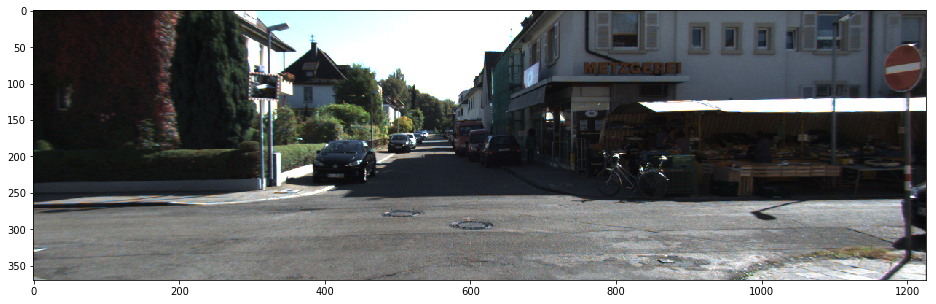

In [3]:
img_name = "000143_10.png"
img1_path = "G:\\data_stereo_flow\\training\colored_0\\"+img_name
img2_path = "G:\\data_stereo_flow\\training\colored_1\\"+img_name
img1 = cv2.imread(img1_path)
img2 = cv2.imread(img2_path)

img_pil1 = Image.fromarray(img1[...,::-1])
img_pil2 = Image.fromarray(img2[...,::-1])

plt.figure(figsize=(16,9))
plt.imshow(img1[...,::-1])

# Detection

In [4]:
tio = time.time()
boxes,classes,scores = yolo.detect_image(img_pil1)# detect
print('it takes %f s'%(time.time()-tio))

it takes 13.472415 s


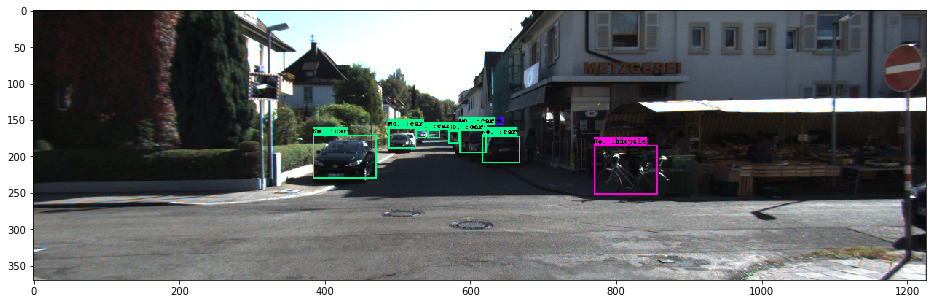

In [5]:
for bbox,cat in zip(boxes,classes):
    color = yolo.colors[yolo.class_names.index(cat)]
    bbox = np.array(bbox)
    bbox[2:] = bbox[:2] + bbox[2:]#tlwh to tlbr
    img_draw1 = draw_box(img_pil1,bbox,' ',cat,color)

plt.figure(figsize=(16,12))
img_show = np.asarray(img_draw1)
plt.imshow(img_show)

# Found Features in Whole Photo

In [6]:
# find correspondence points
pts1, pts2 = features.find_correspondence_points(img1, img2,feature='SURF')
points1 = processor.cart2hom(pts1)
points2 = processor.cart2hom(pts2)

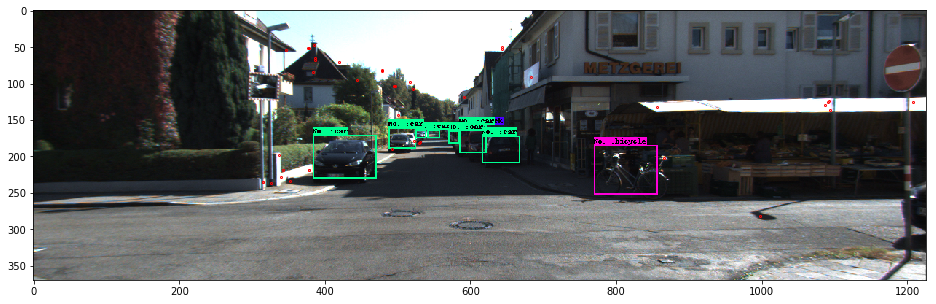

In [7]:
plt.figure(figsize=(16,12))
plt.plot(points1[0],points1[1],'ro',markerfacecolor = 'none', markersize=2)
plt.imshow(img_show)

# Find Feature Point in the BBoxes

has 3 key points
has 3 key points
has 1 key points
has 0 key points
has 0 key points
has 0 key points
has 1 key points
has 19 key points
has 14 key points


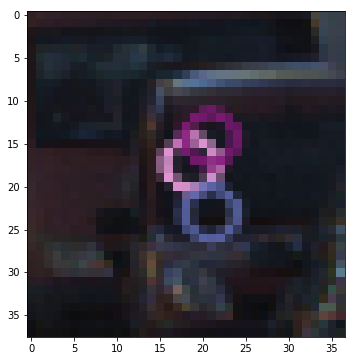

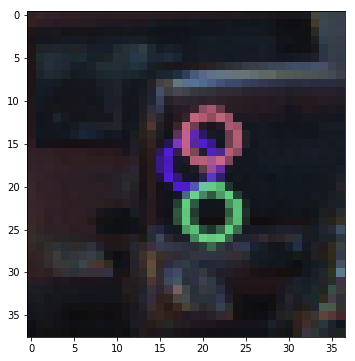

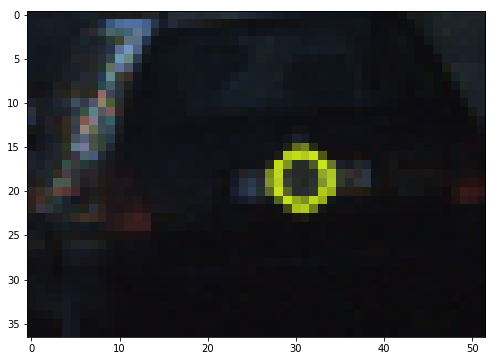

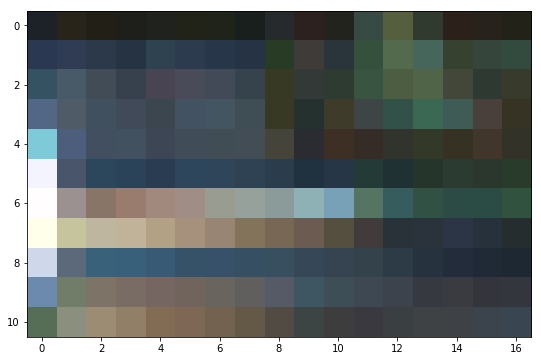

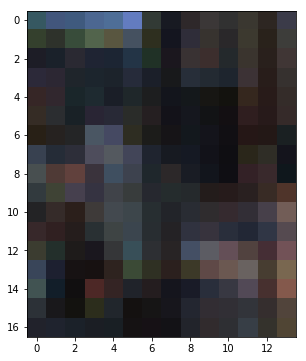

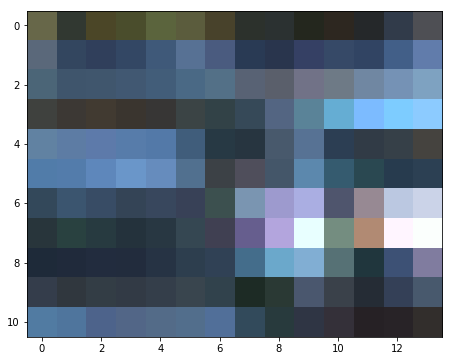

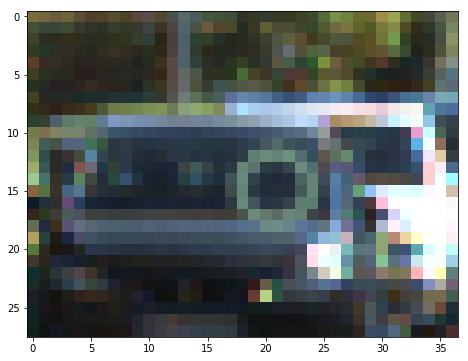

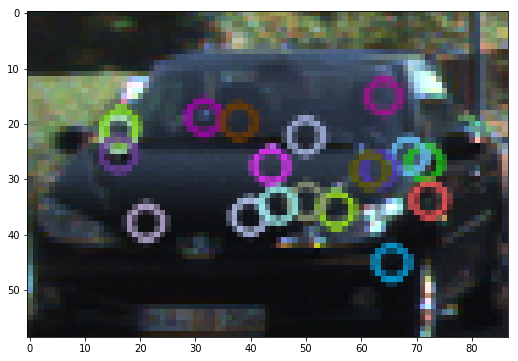

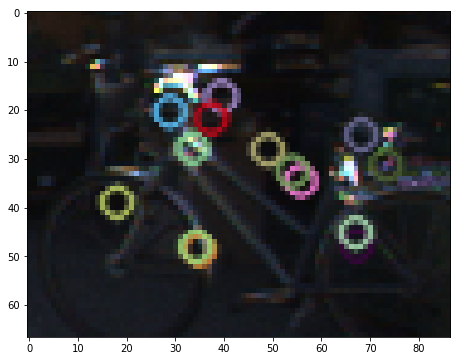

In [8]:
for i in range(len(boxes)):
    l,t,w,h = boxes[i]
    r = l + w;b = t + h
    patch_img = img1[t:b,l:r,:]

    fea = cv2.xfeatures2d.SURF_create()
    kp1, des1 = fea.detectAndCompute(cv2.cvtColor(patch_img, cv2.COLOR_BGR2GRAY), None)
    print("has %d key points"%(len(kp1)))

    plt.figure(figsize=(10,6))
    patch_show = patch_img.copy()
    patch_show = cv2.drawKeypoints(patch_img,kp1,patch_show)#draw key points
    # cv2.imshow('box'+str(i),patch_show[...,::-1])
    plt.imshow(patch_show[...,::-1])

# cv2.waitKey(0)
# cv2.destroyAllWindows()

# Strict Search Range

it takes 0.003004 s
(top,bottom,left,right): 185 252 740 827


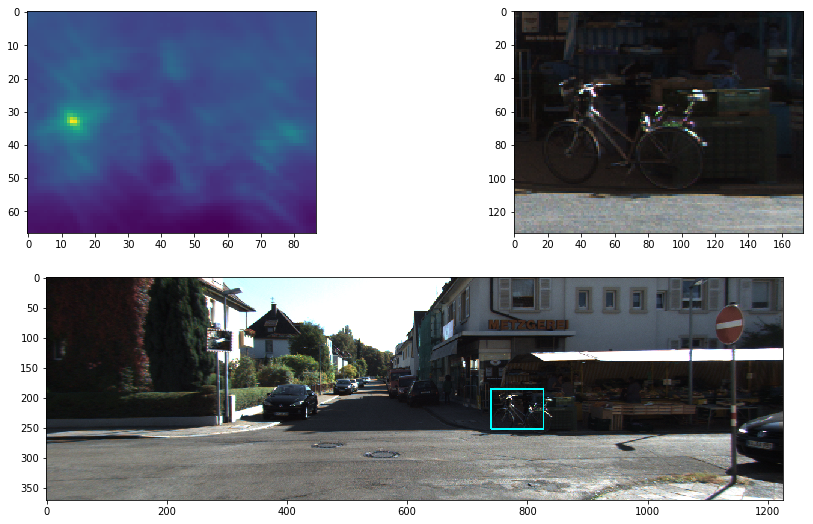

In [100]:
# get template
l,t,w,h = boxes[8]
r = l + w;b = t + h
template = img1[t:b,l:r,:]

# strict search range
ts,bs,rs,ls = np.array([t,b,r,l],dtype='int32') + np.array([-h/2,h/2.,w/2.,-w/2.],dtype='int32')
# ts,bs,rs,ls = np.array([t,b,r,l],dtype='int32') 
ts = max(0,ts);ls = max(0,ls)
bs = min(img2.shape[0],bs); rs = min(img2.shape[1],rs)
# print(ts,bs,rs,ls)
search_patch = img2[ts:bs,ls:rs,:]#search in around the template
tio = time.time()
res = cv2.matchTemplate(search_patch,template,cv2.TM_CCOEFF)
print('it takes %f s'%(time.time()-tio))
min_val,max_val,min_loc,max_loc = cv2.minMaxLoc(res)

# the matched patch's location
left_top = tuple(np.array(max_loc)+np.array([ls,ts]))
r_matched = min(left_top[0]+w,img2.shape[1])
b_matched = min(left_top[1]+h,img2.shape[0])
right_bottom = (r_matched,b_matched)

img = img2.copy()
cv2.rectangle(img,top_left,bottom_right,(255,255,0),2)
print("(top,bottom,left,right):",left_top[1],right_bottom[1],left_top[0],right_bottom[0])

plt.figure(figsize=(16,9))
ax1 = plt.subplot2grid((2,2),(0,0),colspan = 1,rowspan = 1);ax1.imshow(res)
ax2 = plt.subplot2grid((2,2),(0,1),colspan = 1,rowspan = 1);ax2.imshow(search_patch)
ax3 = plt.subplot2grid((2,2),(1,0),colspan = 2,rowspan = 1);ax3.imshow(img[...,::-1])

# Nonstrict search range

it takes 0.102023 s
(top,bottom,left,right): 185 252 740 827


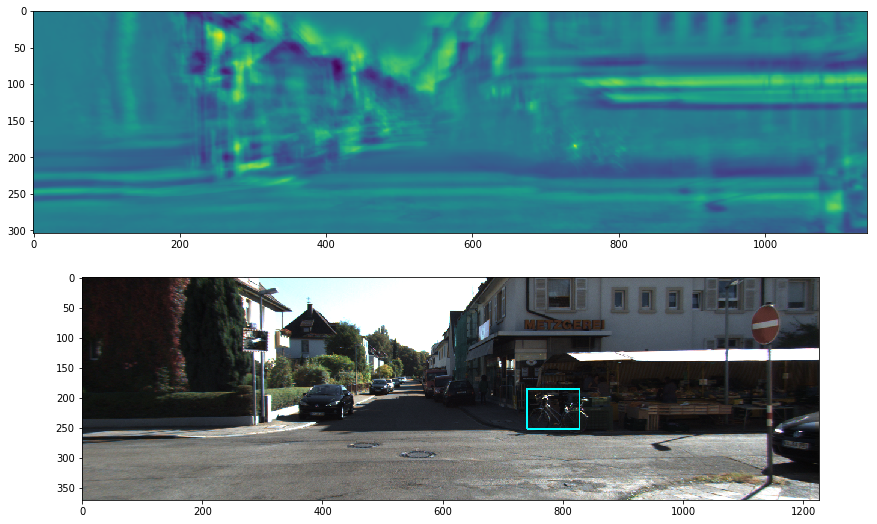

In [82]:
# get template
l,t,w,h = boxes[8]
r = l + w;b = t + h
template = img1[t:b,l:r,:]

search_patch = img2
tio = time.time()
res = cv2.matchTemplate(search_patch,template,cv2.TM_CCOEFF)
print('it takes %f s'%(time.time()-tio))
min_val,max_val,min_loc,max_loc = cv2.minMaxLoc(res)

# the matched patch's location
top_left = max_loc
bottom_right = (top_left[0]+w, top_left[1]+h)

img = img2.copy()
cv2.rectangle(img,top_left,bottom_right,(255,255,0),2)
print("(top,bottom,left,right):",left_top[1],right_bottom[1],left_top[0],right_bottom[0])

plt.figure(figsize=(16,9))
plt.subplot(211);plt.imshow(res)
plt.subplot(212);plt.imshow(img[...,::-1])

In [101]:
boxes[8]

[770, 185, 87, 67]